# Noise correlations and signal-to-noise ratio

## 0. Import some Python packages

In [21]:
import time
import numpy as np
import scipy.signal as ss
import matplotlib.pyplot as plt
from scipy import interpolate
from obspy.signal.filter import bandpass

plt.rcParams["font.family"] = "Times"
plt.rcParams.update({"font.size": 50})
plt.rcParams["xtick.major.pad"] = "12"
plt.rcParams["ytick.major.pad"] = "12"

In this notebook, we explore random wavefield correlations for various signal-to-noise ratios in the case of artificially observed wavefields.

## 1. Input parameters

In [22]:
# Medium setup ======================================

# Radius of device [m].
R = 0.075
# Reference velocity for synthetics [m/s].
c_syn = 1500.0
# Velocity for observations [m/s].
c_obs = 1550.0


# Random sources. ===================================

# Number of sources.
nsrc = 500
# Number of source realisations.
N = 100
# Random seed for reproducibility.
np.random.seed(0)


# Time series and filtering. ========================

# Length of one time series [s].
L = 100.0
T = 2.0 * L * R / c_syn
# Frequency band [Hz].
freqmin = 100.0e3
freqmax = 1000.0e3
# Number of samples in the time series.
n = int(10.0 * T * freqmax)
# Noise to signal ratio.
nsr = 1.25

print("transit time: %g ms" % (2000.0 * R / c_syn))
print("length of individual source: %g ms" % (1000.0 * T))
print("total length of time series: %g s" % (N * T))

# Correlations. =====================================

# Maximum lag time.
max_lag_time = 2.5 * R / c_syn

# Performance checks. ===============================
timing = False

transit time: 0.1 ms
length of individual source: 10 ms
total length of time series: 1 s


In [23]:
df = np.float(n) / T
print("sampling rate = %g Hz" % df)

sampling rate = 1e+07 Hz


## 2. Compute and plot sources and receivers

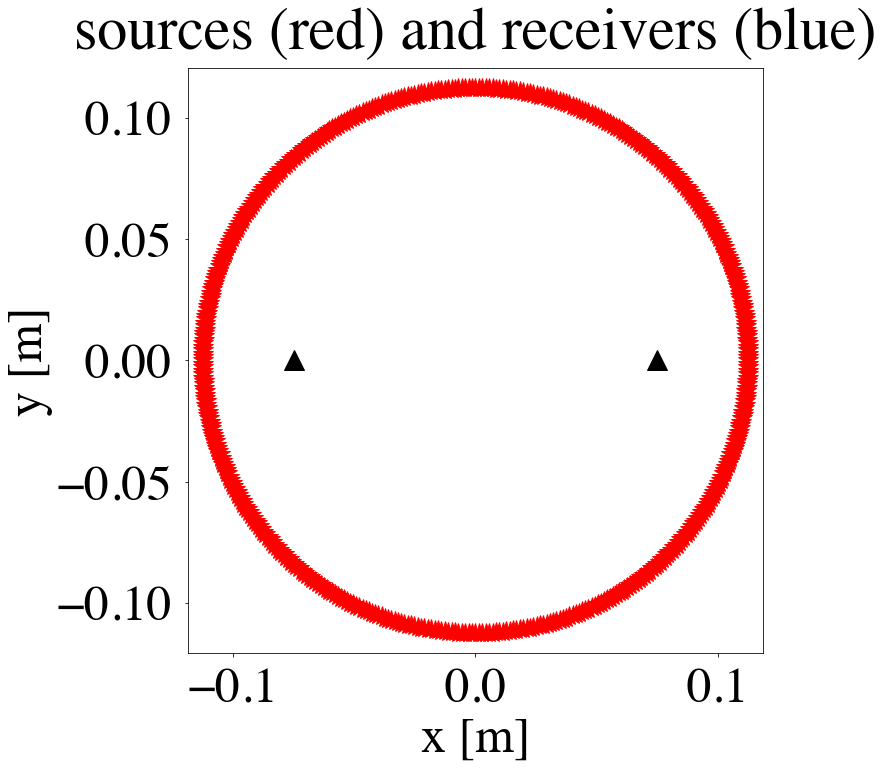

In [36]:
# Source positions.
phi_src = np.arange(0.0, 2.0 * np.pi, 2.0 * np.pi / np.float(nsrc))
x_src = 1.5 * R * np.cos(phi_src)
y_src = 1.5 * R * np.sin(phi_src)

# Receiver positions.
phi_rec = np.arange(0.0, 2.0 * np.pi, np.pi)
x_rec = R * np.cos(phi_rec)
y_rec = R * np.sin(phi_rec)

plt.subplots(1, figsize=(12, 12))
plt.plot(x_src, y_src, "*r", markersize=20)
plt.plot(x_rec, y_rec, "^k", markersize=20)
plt.axis("equal")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.title("sources (red) and receivers (blue)", pad=20)
plt.tight_layout()
plt.show()

## 3. Little helper calculations

In [26]:
# Time increment.
dt = T / np.float(n)
# Maximum lag index.
maxlag = int(max_lag_time / dt)

# Number of sources.
nsrc = len(phi_src)
# Number of receivers.
nrec = len(phi_rec)

## 4. Cross-correlation with limited lag time

This function exists because we are only interested in rather limited lag times that are just a bit larger than the maximum transit time.

In [27]:
def corr(a, b, maxlag):

    n = len(a)
    cc = np.zeros(maxlag)

    for i in range(maxlag):
        cc[i] = np.sum(a[: n - i] * b[i:])

    return cc

## 5. Correlation and stacking

This part does the actual work. It consists in some nested loops:

    - Loop over wavefield realisations. Each realisation corresponds to a random wavefield of a certain duration.
        - Loop over sources. Each source has a random wavelet.
            - Loop over receivers. For each receiver, the time shift and geometric spreading are computed.
        - Loop over receivers which are correlated with receiver 0. Also computes the linear and the phase stack.


In [28]:
# Linear correlation stack.
cc_syn = np.zeros((nrec, maxlag))
cc_obs = np.zeros((nrec, maxlag))
# Phase-weights for phase-weighted stack.
pw_syn = np.zeros((nrec, maxlag), dtype="complex128")
pw_obs = np.zeros((nrec, maxlag), dtype="complex128")

# Loop over realisation.
for i in range(N):

    print("wavefield realisation %d" % i)
    u_syn = np.zeros((nrec, n))
    u_obs = np.zeros((nrec, n))

    # Make random wavefield. ==========================================================

    if timing:
        t1 = time.time()

    # Loop over sources.
    for isrc in range(nsrc):

        if timing:
            t11 = time.time()

        # Time series for one source.
        srcwvlt = 0.5 - np.random.rand(n)

        if timing:
            t12 = time.time()
            print("dt11=%f s" % (t12 - t11))

        # Loop over receivers.
        for irec in range(nrec):

            # Source-receiver distance.
            r = np.sqrt(
                (x_rec[irec] - x_src[isrc]) ** 2 + (y_rec[irec] - y_src[isrc]) ** 2
            )
            # Time shift.
            shift_t_syn = r / c_syn
            shift_t_obs = r / c_obs
            # Index shift.
            shift_n_syn = int(np.round(shift_t_syn / dt))
            shift_n_obs = int(np.round(shift_t_obs / dt))
            # Assign shifted time series to receiver and apply 2D geometric spreading.
            u_syn[irec, shift_n_syn:] += srcwvlt[0 : n - shift_n_syn] / np.sqrt(r)
            u_obs[irec, shift_n_obs:] += srcwvlt[0 : n - shift_n_obs] / np.sqrt(r)

        if timing:
            t13 = time.time()
            print("dt12=%f s" % (t13 - t12))

    if timing:
        t2 = time.time()
        print("dt1=%f s" % (t2 - t1))

    # Add noise to the observations. ==================================================
    for irec in range(nrec):
        noise = 2.0 * nsr * (0.5 - np.random.rand(n)) * np.max(u_obs[irec, :])
        u_obs[irec, :] += noise

    # Compute and stack correlations. =================================================
    for irec in range(1, nrec):
        # Correlation.
        cc_i_syn = corr(u_syn[0, :], u_syn[irec, :], maxlag)
        cc_i_obs = corr(u_obs[0, :], u_obs[irec, :], maxlag)
        # Bandpass.
        cc_i_syn = bandpass(
            cc_i_syn, freqmin=freqmin, freqmax=freqmax, df=df, corners=4, zerophase=True
        )
        cc_i_obs = bandpass(
            cc_i_obs, freqmin=freqmin, freqmax=freqmax, df=df, corners=4, zerophase=True
        )
        # Linear stack.
        cc_syn[irec, :] += cc_i_syn
        cc_obs[irec, :] += cc_i_obs
        # Phase weights.
        h_syn = ss.hilbert(cc_i_syn)
        h_obs = ss.hilbert(cc_i_obs)
        pw_syn[irec, :] += h_syn / np.abs(h_syn)
        pw_obs[irec, :] += h_obs / np.abs(h_obs)

    if timing:
        t3 = time.time()
        print("dt2=%f s" % (t3 - t2))

# Normalise.
cc_syn = cc_syn / np.max(cc_syn)
cc_obs = cc_obs / np.max(cc_obs)
pw_syn = np.abs(pw_syn / np.max(pw_syn))
pw_obs = np.abs(pw_obs / np.max(pw_obs))

wavefield realisation 0
wavefield realisation 1
wavefield realisation 2
wavefield realisation 3
wavefield realisation 4
wavefield realisation 5
wavefield realisation 6
wavefield realisation 7
wavefield realisation 8
wavefield realisation 9
wavefield realisation 10
wavefield realisation 11
wavefield realisation 12
wavefield realisation 13
wavefield realisation 14
wavefield realisation 15
wavefield realisation 16
wavefield realisation 17
wavefield realisation 18
wavefield realisation 19
wavefield realisation 20
wavefield realisation 21
wavefield realisation 22
wavefield realisation 23
wavefield realisation 24
wavefield realisation 25
wavefield realisation 26
wavefield realisation 27
wavefield realisation 28
wavefield realisation 29
wavefield realisation 30
wavefield realisation 31
wavefield realisation 32
wavefield realisation 33
wavefield realisation 34
wavefield realisation 35
wavefield realisation 36
wavefield realisation 37
wavefield realisation 38
wavefield realisation 39
wavefield 

## 6. Plot results

In [29]:
# Receiver index.
irec = 1

In [30]:
cc_syn_pw = (pw_syn[irec, :] ** 2.0) * cc_syn[irec, :]
cc_obs_pw = (pw_obs[irec, :] ** 2.0) * cc_obs[irec, :]

predicted traveltime: 0.100000 ms


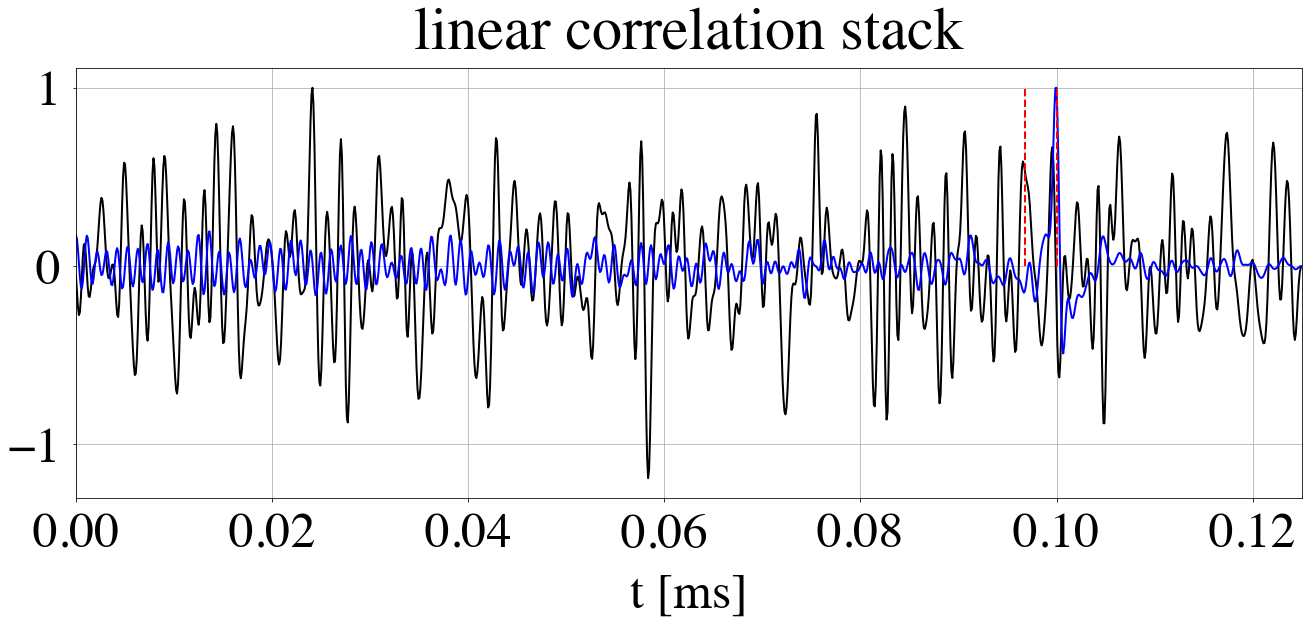

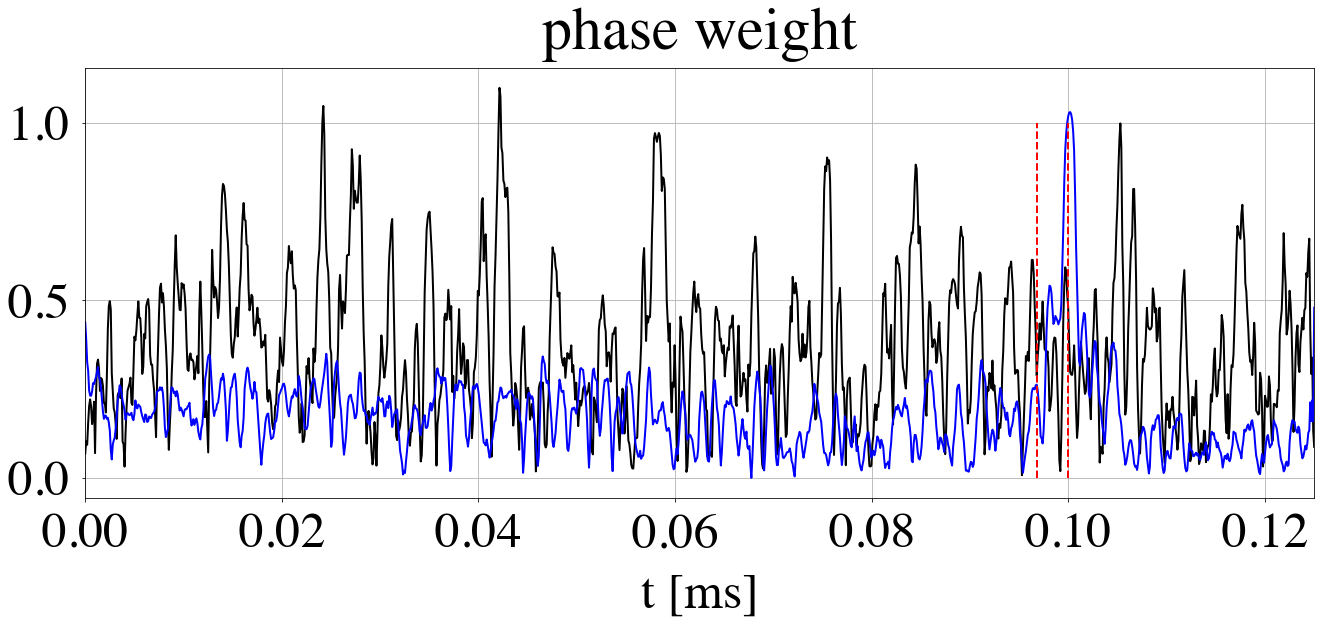

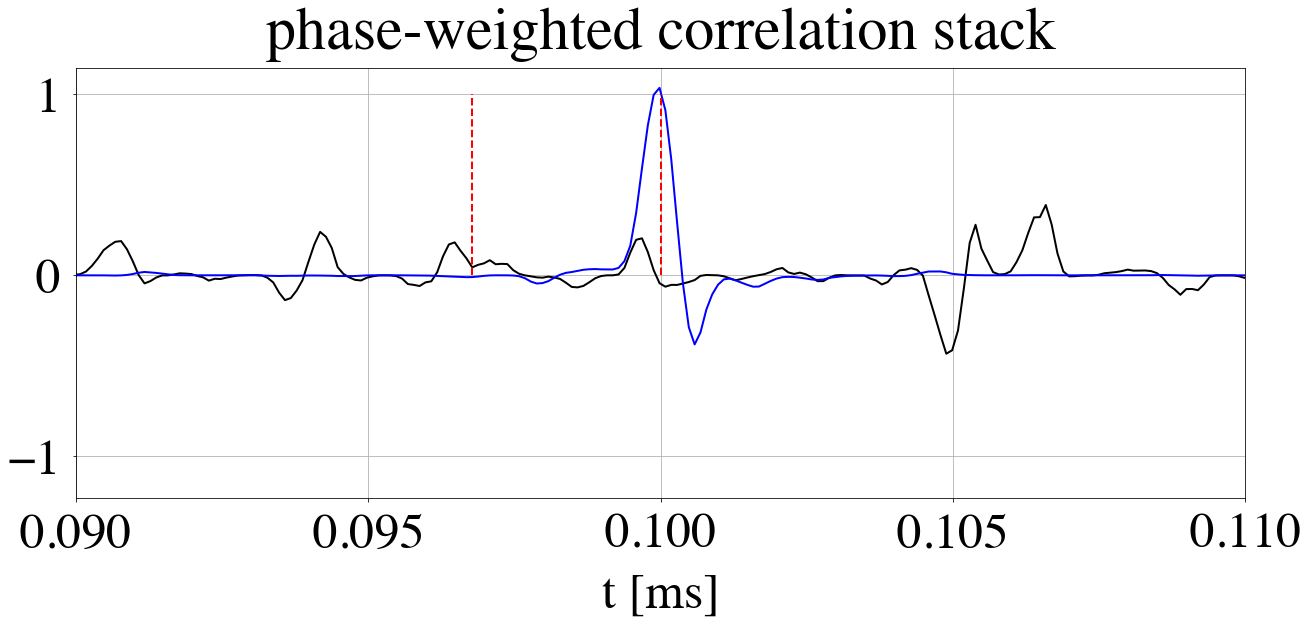

In [34]:
# Predicted traveltimes between receiver 0 and receiver irec.
tt_syn = (
    1000
    * np.sqrt((x_rec[0] - x_rec[irec]) ** 2 + (y_rec[0] - y_rec[irec]) ** 2)
    / c_syn
)
tt_obs = (
    1000
    * np.sqrt((x_rec[0] - x_rec[irec]) ** 2 + (y_rec[0] - y_rec[irec]) ** 2)
    / c_obs
)
print("predicted traveltime: %f ms" % tt_syn)

# Time axis [ms].
t = 1000.0 * np.linspace(0.0, np.float(maxlag) * dt, maxlag)

plt.subplots(1, figsize=(20, 10))
plt.plot(t, cc_obs[irec, :], "k", linewidth=2.0)
plt.plot(t, cc_syn[irec, :], "b", linewidth=2.0)
plt.plot([tt_obs, tt_obs], [0.0, 1.0], "--r", linewidth=2.0)
plt.plot([tt_syn, tt_syn], [0.0, 1.0], "--r", linewidth=2.0)
plt.xlabel("t [ms]", labelpad=15)
plt.xlim([t[0], t[-1]])
plt.title("linear correlation stack", pad=20)
plt.grid()
plt.tight_layout()
plt.show()

plt.subplots(1, figsize=(20, 10))
plt.plot(t, pw_obs[irec, :], "k", linewidth=2.0)
plt.plot(t, pw_syn[irec, :], "b", linewidth=2.0)
plt.plot([tt_obs, tt_obs], [0.0, 1.0], "--r", linewidth=2.0)
plt.plot([tt_syn, tt_syn], [0.0, 1.0], "--r", linewidth=2.0)
plt.xlabel("t [ms]", labelpad=15)
plt.xlim([t[0], t[-1]])
plt.grid()
plt.title("phase weight", pad=20)
plt.tight_layout()
plt.show()

plt.subplots(1, figsize=(20, 10))
plt.plot(t, cc_obs_pw, "k", linewidth=2.0)
plt.plot(t, cc_syn_pw, "b", linewidth=2.0)
plt.plot([tt_obs, tt_obs], [0.0, 1.0], "--r", linewidth=2.0)
plt.plot([tt_syn, tt_syn], [0.0, 1.0], "--r", linewidth=2.0)
plt.xlabel("t [ms]", labelpad=15)
# plt.xlim([t[0],t[-1]])
plt.xlim([0.09, 0.11])
plt.grid()
plt.title("phase-weighted correlation stack", pad=20)
plt.tight_layout()
plt.show()

## 7. Compute time shifts

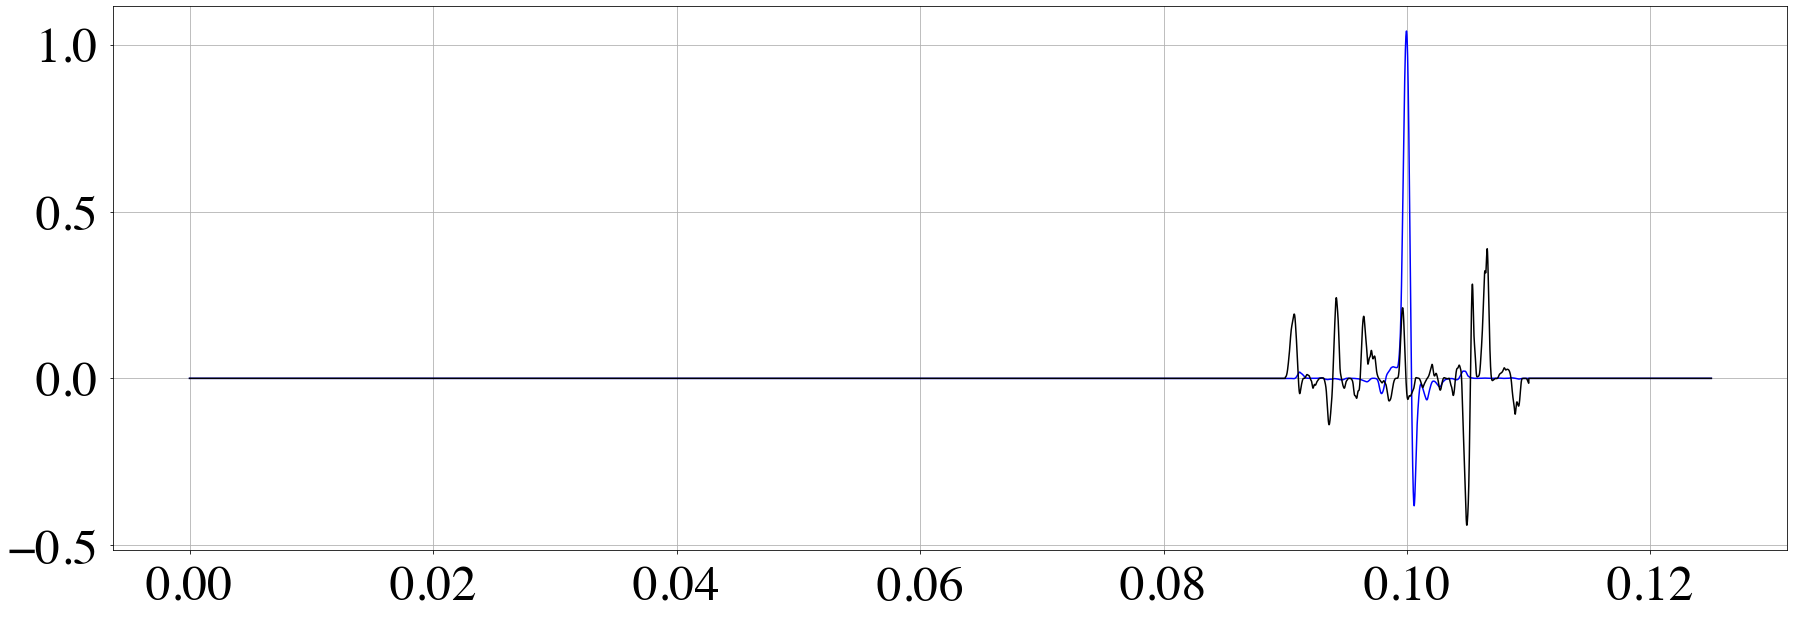

analytical time shift: 0.00322581 ms
numerical time shift: 0.00570786 ms
absolute time shift error: -0.00248205 ms
relative time shift error: -2.48205 percent
velocity error: 37.2308 m/s


In [33]:
# Analytical traveltime difference. =====================================

dtt_analytic = tt_syn - tt_obs

# Traveltime difference by waveform correlation. ========================

# Interpolate to increase time resolution.
f_syn = interpolate.interp1d(t, cc_syn_pw, kind="cubic")
f_obs = interpolate.interp1d(t, cc_obs_pw, kind="cubic")

t_interp = 1000.0 * np.linspace(0.0, np.float(maxlag) * dt, 50 * maxlag)
cc_syn_interp = f_syn(t_interp)
cc_obs_interp = f_obs(t_interp)

# Define measurement window.
T_win = 1000.0 / freqmin
t_min = tt_syn - T_win
t_max = tt_syn + T_win
win = np.array([t_interp > t_min]).astype(float) * np.array([t_interp < t_max]).astype(
    float
)
win = win[0]

# Plot interpolated correlations.
plt.subplots(1, figsize=(30, 10))
plt.plot(t_interp, win * cc_syn_interp, "b")
plt.plot(t_interp, win * cc_obs_interp, "k")
plt.grid()
# plt.xlim([0.120,0.150])
plt.show()

n_shift = int(2.0 * np.abs((tt_syn - tt_obs) / (t_interp[1] - t_interp[0])))
cc = corr(win * cc_obs_interp, win * cc_syn_interp, n_shift)
tt = np.linspace(0.0, n_shift * (t_interp[1] - t_interp[0]), n_shift)

dtt_numeric = np.float(tt[np.max(cc) == cc])

plt.subplots(1, figsize=(30, 10))
plt.plot(tt, cc)
plt.xlabel("t [ms]")
plt.grid()
plt.show()

# Results. ===============================================================

print("analytical time shift: %g ms" % dtt_analytic)
print("numerical time shift: %g ms" % dtt_numeric)
ddtt = dtt_analytic - dtt_numeric
print("absolute time shift error: %g ms" % ddtt)
ddtt_rel = 100.0 * ddtt / tt_syn
print("relative time shift error: %g percent" % ddtt_rel)
dv = -c_syn * ddtt / tt_syn
print("velocity error: %g m/s" % dv)